### Week 5: Artificial Neural Network and Support Vector Machine!
###### Joel Konitzer
###### 9/24/2022

In [61]:
#Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sklearn packages
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score,cross_validate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,classification_report, confusion_matrix, precision_score

# Plotting packages
import seaborn as sns

# Custom functions
import EDAFunctions
import PerformanceMetrics

# Remove plt.show()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load creditcard.csv data
df = pd.read_csv('creditcard.csv')

In [3]:
#Preview data & shape
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

### Feature selection & EDA

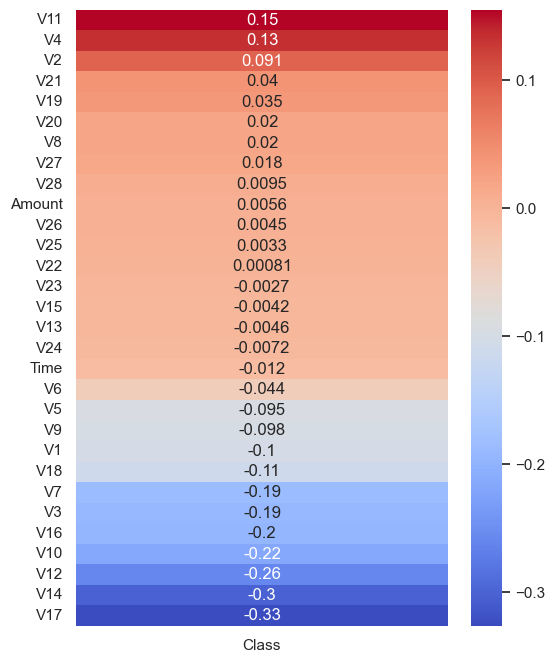

In [5]:
#Use custom function visuals to find correlated features
EDAFunctions.corr_to_target(df, 'Class', title=None, file=None)

Since there are many features in the middle that are similar in magnitiude, I'll only retain the top and bottom features.

In [6]:
cols = ['Class','Amount','V11','V4','V2','V21','V19','V17','V14']
df = df[cols].copy()

In [7]:
df.head()

,Class,Amount,V11,V4,V2,V21,V19,V17,V14
0,0,149.62,-0.551600,1.378155,-0.072781,-0.018307,0.403993,0.207971,-0.311169
1,0,2.69,1.612727,0.448154,0.266151,-0.225775,-0.145783,-0.114805,-0.143772
2,0,378.66,0.624501,0.379780,-1.340163,0.247998,-2.261857,1.109969,-0.165946
3,0,123.50,-0.226487,-0.863291,-0.185226,-0.108300,-1.232622,-0.684093,-0.287924
4,0,69.99,-0.822843,0.403034,0.877737,-0.009431,0.803487,-0.237033,-1.119670


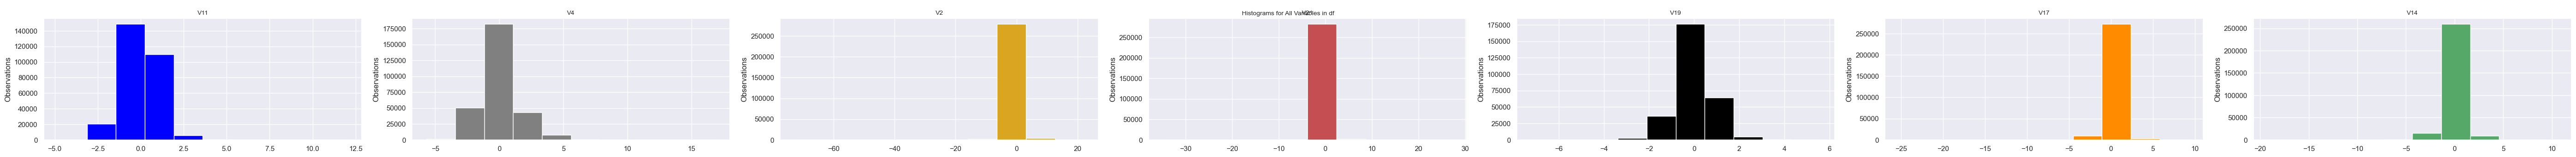

In [8]:
#View value feature distribution
EDAFunctions.gen_histograms(df.drop(['Class','Amount'], axis=1), 7)

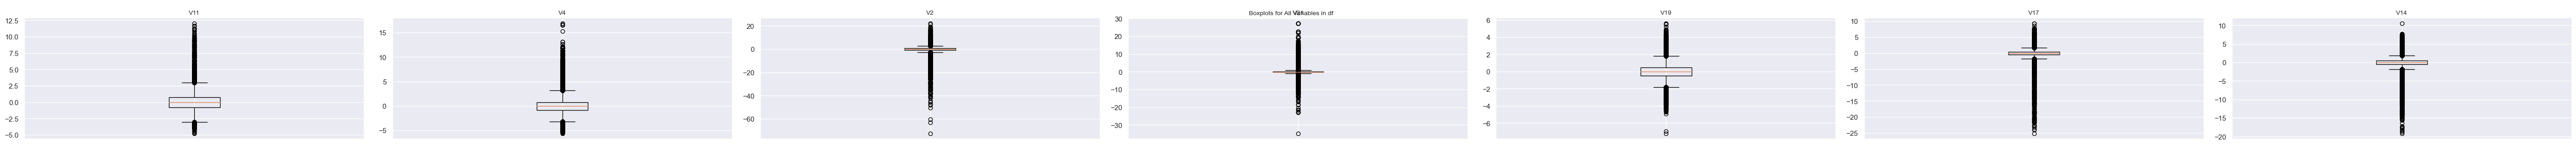

In [9]:
#View value spread
EDAFunctions.gen_boxplots(df.drop(['Class','Amount'],axis=1), 7)

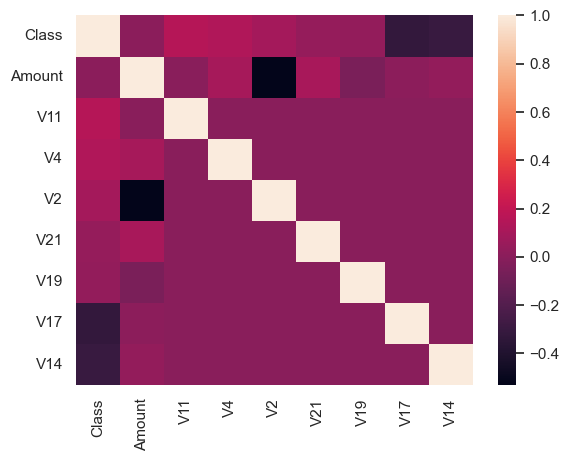

In [10]:
#Check correlations again
_ = sns.heatmap(df.corr())

#### Transform feature values
- Transforming the dataset 

In [11]:
#gather up names of all the columns
cols = df.columns

#set the prediction column and the feature columns for KNN
prediction_col = 'Class'
feature_cols = [c for c in cols if c != prediction_col]

x = df[feature_cols]
y = df[prediction_col]

#split the dataset into the train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=41)

In [12]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(x_train)

x_train = scaler.transform(x_train)  
x_test = scaler.transform(x_test)

#### Normal run

In [13]:
from sklearn.neural_network import MLPClassifier  

mlp = MLPClassifier(max_iter=100, random_state=42, early_stopping=True)
mlp.fit(x_train, y_train.values.ravel())  

MLPClassifier(early_stopping=True, max_iter=100, random_state=42)

In [14]:
# make predictions
predictions_norm = mlp.predict(x_test)

### Optimizing MLPClassifier with GridSearchCV

In [17]:
#Required sklearn packages
from sklearn.neural_network import MLPClassifier  
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import time

In [18]:
# Set grid search parameters
#Represents the number of neurons in the ith hidden layer.
hidden_layer_sizes = [(10,30,10),(5,15,5),(10,50,10)]
#Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
alpha = [0.0001, 0.01, 0.05]
#Creating grid
para = {'hidden_layer_sizes': hidden_layer_sizes,
        'alpha': alpha}
print(para)

{'hidden_layer_sizes': [(10, 30, 10), (5, 15, 5), (10, 50, 10)], 'alpha': [0.0001, 0.01, 0.05]}


#### GridSearchCV
##### Perform an exsaustive over specified parameters to find the best estimator

In [20]:
# Set grid search parameters
grid_search = GridSearchCV(estimator =  MLPClassifier(random_state=42, max_iter=100),verbose=True, param_grid = para, cv = 5,  n_jobs = -1)
# Fit the random search model
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100, random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.01, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (5, 15, 5),
                                                (10, 50, 10)]},
             verbose=True)

In [21]:
# View best parameters from grid search results
grid_search.best_params_

{'alpha': 0.01, 'hidden_layer_sizes': (10, 30, 10)}

In [22]:
# Fit model with best parameters from grid search results
mlp_gridCV = MLPClassifier(hidden_layer_sizes =(10, 30, 10), max_iter=100,random_state=42, alpha = 0.01, early_stopping=True)
mlp_gridCV.fit(x_train, y_train.values.ravel())  

MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=(10, 30, 10),
              max_iter=100, random_state=42)

In [23]:
# Set prediction value with grid search model 
predictions_grid = mlp_gridCV.predict(x_test)  

#### HalvingGridSearchCV
##### Demonstrating an additional grid search method called Halving Grid Search. 
##### "The search strategy starts evaluating all the candidates with a small amount of resources and iteratively selects the best candidates, using more and more resources."
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn.model_selection.HalvingGridSearchCV

In [24]:
# Duplicate parameters used in previous grid search to ensure repeatability
Halving_grid_search = HalvingGridSearchCV(estimator =  MLPClassifier(random_state=42, max_iter=100),verbose=True, param_grid = para, cv = 5,  n_jobs = -1)
# Fit the random search model
Halving_grid_search.fit(x_train,y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 25316
max_resources_: 227845
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 25316
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 1
n_candidates: 3
n_resources: 75948
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 1
n_resources: 227844
Fitting 5 folds for each of 1 candidates, totalling 5 fits


HalvingGridSearchCV(estimator=MLPClassifier(max_iter=100, random_state=42),
                    n_jobs=-1,
                    param_grid={'alpha': [0.0001, 0.01, 0.05],
                                'hidden_layer_sizes': [(10, 30, 10), (5, 15, 5),
                                                       (10, 50, 10)]},
                    verbose=True)

In [25]:
# Set prediction value with halving grid search model 
Halving_grid_search.best_params_

{'alpha': 0.05, 'hidden_layer_sizes': (10, 30, 10)}

In [44]:
# Fit model with best parameters from grid search results
mlp_searched = MLPClassifier(hidden_layer_sizes =(10, 30, 10), max_iter=100,random_state=42, alpha = 0.05, early_stopping=True) #Replaced alpha of 0.01 in grid search for 0.05 given from halving grid search
mlp_searched.fit(x_train, y_train.values.ravel())  

MLPClassifier(alpha=0.05, early_stopping=True, hidden_layer_sizes=(10, 30, 10),
              max_iter=100, random_state=42)

In [45]:
# make predictions
predictions_halvesearch = mlp_searched.predict(x_test)  

### View performance metrics
##### Performance metrics are broken down by model parameters and then plotted together to compare model performance

In [62]:
print("Confusion Matrix \nDefault parameters: \n", confusion_matrix(y_test,predictions_norm))

Confusion Matrix 
Default parameters: 
 [[56858    10]
 [   28    66]]


In [63]:
print("Classification report \nDefault parameters: \n", classification_report(y_test,predictions_norm))
_,precision_basetest, recall_basetest, f1_basetest = PerformanceMetrics.eval_model_test(mlp, x_test, y_test)

Classification report 
Default parameters: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.87      0.70      0.78        94

    accuracy                           1.00     56962
   macro avg       0.93      0.85      0.89     56962
weighted avg       1.00      1.00      1.00     56962



In [64]:
print("Confusion Matrix \nExhaustive Grid Search: \n", confusion_matrix(y_test,predictions_grid))  

Confusion Matrix 
Exhaustive Grid Search: 
 [[56859     9]
 [   25    69]]


In [65]:
print("Classification report \nExhaustive Grid Search: \n",classification_report(y_test,predictions_grid)) 

Classification report 
Exhaustive Grid Search: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.88      0.73      0.80        94

    accuracy                           1.00     56962
   macro avg       0.94      0.87      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [66]:
print("Confusion Matrix \nHalving Grid Search: \n", confusion_matrix(y_test,predictions_halvesearch)) 

Confusion Matrix 
Halving Grid Search: 
 [[56856    12]
 [   24    70]]


In [67]:
print("Classification report \nHalving Grid Search: \n", classification_report(y_test,predictions_halvesearch)) 

Classification report 
Halving Grid Search: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56868
           1       0.85      0.74      0.80        94

    accuracy                           1.00     56962
   macro avg       0.93      0.87      0.90     56962
weighted avg       1.00      1.00      1.00     56962



##### Validation loss - all three models

Text(0.5, 1.0, 'Loss Curve')

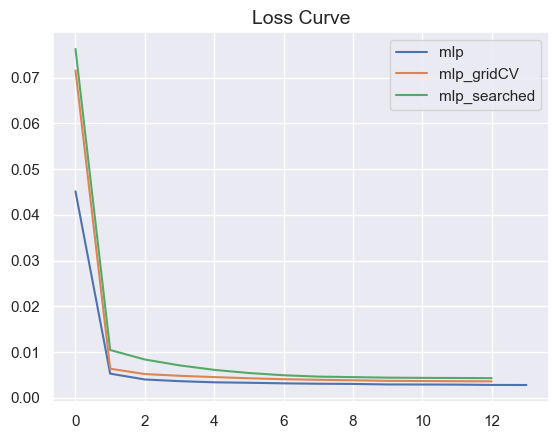

In [85]:
#Plot each model using loss_curve_ attribute from MLPClassifier class 
plt.plot(mlp.loss_curve_)
plt.plot(mlp_gridCV.loss_curve_)
plt.plot(mlp_searched.loss_curve_)
plt.legend(['mlp','mlp_gridCV','mlp_searched'])
plt.title("Loss Curve", fontsize=14)

Text(0.5, 1.0, 'Validation Scores')

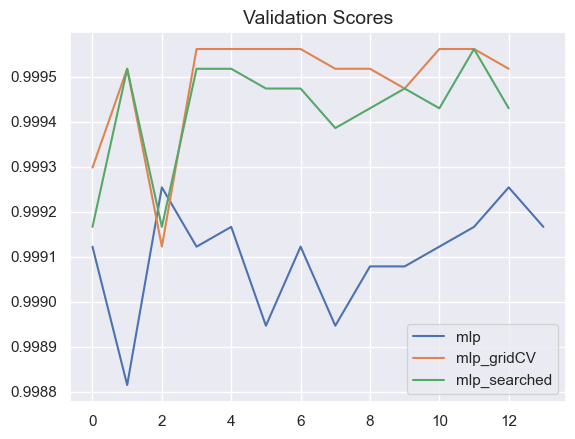

In [88]:
#Plot each model using validation_scores_ attribute from MLPClassifier class 
#Needed to add early_stopping=True for this to function properly
plt.plot(mlp.validation_scores_)
plt.plot(mlp_gridCV.validation_scores_)
plt.plot(mlp_searched.validation_scores_)
plt.legend(['mlp','mlp_gridCV','mlp_searched'])
plt.title("Validation Scores", fontsize=14)

##### Summary analysis:

###### This exercise demonstrates preparing an Artificial Neural network classifier to predict some binary outcomes using the sci-kit-learn MLPClassifier. In addition to evaluating model performance with default parameters, two types of grid searches are performed to identify optimal hyperparameters. The dataset used for this analysis is credit card user details with a predictor that indicates positive fraudulent activity. 
###### Not every dataset feature was used; only the highest and lowest correlated features were retained and standardized before fitting to the MLP classifier. The performance metrics section breaks down the results. Looking at the confusion matrices for each model, it appears the exhaustive grid search model performed the best. Precision for this model is the highest and is further confirmed by the first quadrant in the confusion matrix, showing fewer false positives than the other models. Precision could be an essential metric to keep track of when detecting credit card fraud. 
###### Since the outcome column is binary, the F1 score will be necessary for validating model performance. The F1 score was 0.79 for the model using default parameters, and the grid search models had an increased score of 0.80. The loss and validation curves are shown for all three models, and the optimized models offer better performance in lower loss and higher scores. A more exhaustive search using other grid search methods in the future should be explored.

Citations:

###### API reference. scikit. (n.d.). Retrieved September 25, 2022, from https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network 
###### Sklearn.model_selection.GRIDSEARCHCV. scikit. (n.d.). Retrieved September 25, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV 
###### Sklearn.model_selection.HALVINGGRIDSEARCHCV. scikit. (n.d.). Retrieved September 25, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn.model_selection.HalvingGridSearchCV 
###### Sklearn.neural_network.MLPClassifier. scikit. (n.d.). Retrieved September 25, 2022, from https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier 